In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

# Data generation
np.random.seed(42)
torch.manual_seed(42)

n_samples = 1000
x = np.random.uniform(-2, 2, (n_samples, 2))
y = np.sin(x[:, 0]) + np.cos(x[:, 1]) + x[:, 0]**2 - x[:, 1]**2

X = torch.tensor(x, dtype=torch.float32)
Y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [2]:
# PiecewiseLinear Transform
class PiecewiseLinear(nn.Module):
    def __init__(self, segments=10, input_range=(-2, 2)):
        super().__init__()
        self.segments = segments
        self.input_range = input_range
        self.knots = torch.linspace(*input_range, segments)
        self.slopes = nn.Parameter(torch.randn(segments - 1))
        self.biases = nn.Parameter(torch.randn(segments - 1))

    def forward(self, x):
        out = torch.zeros_like(x)
        for i in range(self.segments - 1):
            mask = (x >= self.knots[i]) & (x < self.knots[i + 1])
            out[mask] = self.slopes[i] * (x[mask] - self.knots[i]) + self.biases[i]
        return out

In [3]:
# KAN Modelling
class KAN(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.trans_x = PiecewiseLinear()
        self.trans_y = PiecewiseLinear()
        self.linear = nn.Linear(2, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x1 = self.trans_x(x[:, 0])
        x2 = self.trans_y(x[:, 1])
        out = torch.stack([x1, x2], dim=1)
        out = torch.relu(self.linear(out))
        return self.output(out)

In [4]:
# Fully connected neural network
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
# Training Function
def train_model(model, X_train, Y_train, X_val, Y_val, epochs=200, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses, val_losses = [], []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, Y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, Y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

    duration = time.time() - start_time
    return train_losses, val_losses, duration

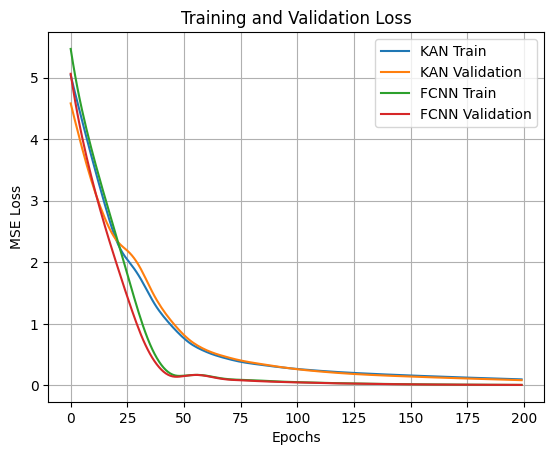

Comparision Results
------------------------------
KAN Parameter Count:        165
FCNN Parameter Count:       129
KAN Training Time:           1.38 s
FCNN Training Time:          0.22 s
KAN Validation Error:        0.0863
FCNN Validation Error:       0.0090


In [6]:
# Training and Comparision
kan_model = KAN()
fcnn_model = FeedForward()

kan_train_loss, kan_val_loss, kan_time = train_model(kan_model, X_train, Y_train, X_val, Y_val)
fcnn_train_loss, fcnn_val_loss, fcnn_time = train_model(fcnn_model, X_train, Y_train, X_val, Y_val)

# Plot drawing
plt.plot(kan_train_loss, label='KAN Train')
plt.plot(kan_val_loss, label='KAN Validation')
plt.plot(fcnn_train_loss, label='FCNN Train')
plt.plot(fcnn_val_loss, label='FCNN Validation')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Comparision Function
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Comparision Results")
print("-" * 30)
print(f"KAN Parameter Count:        {count_params(kan_model)}")
print(f"FCNN Parameter Count:       {count_params(fcnn_model)}")
print(f"KAN Training Time:           {kan_time:.2f} s")
print(f"FCNN Training Time:          {fcnn_time:.2f} s")
print(f"KAN Validation Error:        {kan_val_loss[-1]:.4f}")
print(f"FCNN Validation Error:       {fcnn_val_loss[-1]:.4f}")